In [119]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
    import torch
    from IPython.core.display import HTML
    from IPython.display import display
    import os
    print("Running in Google Colab")
    if not torch.cuda.is_available():
        display(HTML("""<div style="background-color: red; font-weight: bold; color: white;">You have not activated a GPU in Google Colab. Follow the instructions in the <code style="color: white;">README</code></div>"""))
    print("Installing requirements")
    requirements_url = "https://raw.githubusercontent.com/willdalh/ml-course/main/requirements.txt"
    if not os.path.exists('requirements.txt'):
        !wget {requirements_url}
    %pip install --user -r requirements.txt

In [120]:
import sys
sys.path.append('../')

## Nevrale nettverk med PyTorch
Nevrale nettverk har tilsynelatende komplekse strukturer. Likevel består de av flere enkle og isolerte komponenter. Disse finner man i `torch.nn`. 

De fleste komponentene blir et _lag_ i nettverket, men det finnes komponenter som anvendes på eksisterende lag (feks aktiveringsfunksjoner). 

In [121]:
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

Den enkleste komponenten man finner i nevrale nettverk er lineære lag. Matematisk gjør den en lineær transformasjon fra et vektorrom til et annet. Feks kan det lineære laget ta inn en vektor med 3 features, og outputte en vektor med 2 features:



<div >
<img src="../res/nn_3in_2out.png" width="30%" alt="SVG Image"/>
</div>

Hver node representerer en numerisk verdi. En kobling mellom to noder indikerer en vekt, som ganges sammen med verdien fra en node til venstre og summeres sammen med alle de andre koblingene som går inn i en node til høyre. Vi kommer til å erfare at dette utføres som én matriseoperasjon.


I PyTorch lager vi lineære lag gjennom `torch.nn.Linear`.

In [122]:
layer = nn.Linear(in_features=3, out_features=2) # Construct layer
layer

Linear(in_features=3, out_features=2, bias=True)

In [123]:
data = torch.Tensor([[1, 1, 1]])
print(f"Input vector: {data}")
output = layer(data) # Feed data into layer
print(f"Output vector: {output}")

Input vector: tensor([[1., 1., 1.]])
Output vector: tensor([[-0.0365,  0.0958]], grad_fn=<AddmmBackward0>)


Vektoren, som består av 3 enere, har blitt til transformert til en vektor med 2 tall. Vi studerer _vektene_ til det lineære laget.

In [124]:
print(layer.weight)
print(f"Weight shape: {layer.weight.shape}\n")

Parameter containing:
tensor([[ 0.1089, -0.5741,  0.2255],
        [-0.1529,  0.2941, -0.1458]], requires_grad=True)
Weight shape: torch.Size([2, 3])



Matrisen viser tallene som tilhører hver linje som trekkes mellom nodene i figuren over. 

I tillegg til vektene, har lineære lag et konstantledd. Denne adderes på resultatet fra matriseoperasjonen. 

In [125]:
print(layer.bias)
print(f"Bias shape: {layer.bias.shape}")

Parameter containing:
tensor([0.2032, 0.1004], requires_grad=True)
Bias shape: torch.Size([2])


Når man sender input-vektoren inn skjer følgende operasjon (hvor `@` er matrisemultiplikasjon):

In [126]:
print(data @ layer.weight.T + layer.bias)
print(f"data @ layer.weight.T + layer.bias is similar to layer(data): {(data @ layer.weight.T + layer.bias == layer(data)).all()}")

tensor([[-0.0365,  0.0958]], grad_fn=<AddBackward0>)
data @ layer.weight.T + layer.bias is similar to layer(data): True


Vi ser fra resultatet over at det stemmer.


Vektene og biaset utgjør til sammen **parametrene** for dette lineære laget, og er verdiene som endres når man trener nettverket. Andre typer lag har også vekter og bias, men hvordan de er strukturert og brukes varierer. Til denne introduksjonen begrenser vi oss til lineære lag, men sjekk ut `bonus_convnet.ipynb` for å se hvordan man bruker konvolusjonelle lag. 

### Aktiveringsfunksjoner

Det lineære laget utfører en lineær operasjon. Fleksibiliteten av nevrale nettverk kommer derimot av såkalte _aktiveringsfunksjoner_ som utfører ikke-lineære operasjoner på data. Disse inneholder **vanligvis ikke** trenbare parametre. De enkleste opererer på hvert element av en tensor individuelt, som feks Tanh. Av denne grunn modifiseres ikke _shapen_ til tensoren. Vi ser på et en-dimensjonalt-case for å visualisere det enkelt.

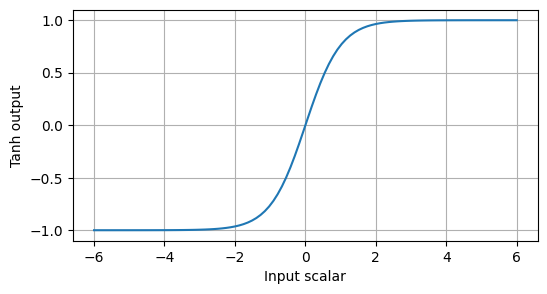

In [127]:
import matplotlib.pyplot as plt # Library for visualization
tanh = nn.Tanh()
assert not hasattr(tanh, "weight") # No learnable weights

data = torch.linspace(start=-6, end=6, steps=100) # Vector with 100 elements increasing from -6 to 6 
output = tanh(data)

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(data, output)
ax.set_xlabel("Input scalar")
ax.set_ylabel("Tanh output")
ax.grid(True)

En annen viktig er `nn.Softmax`, og brukes til å transformere en vektor til elementer som summeres til 1. 

Dette gjør den litt annerledes enn Tanh, siden vi må spesifisere en av shape-dimensjonene som skal summeres til 1.

For denne anledningen tar vi også i bruk `nn.functional`, som er et delbibliotek som tilbyr komponentene tilstandsfrie. 

In [128]:
import torch.nn.functional as F

torch.manual_seed(42)
data = torch.randint(low=1, high=10, size=(3, 2)).float()
print(f"Original data:\n{data}")
data = F.softmax(data, dim=1)
print(f"Transformed data, normalized along columns:\n{data}")
print(f"Summing individual batch elements:\n{data.sum(dim=1)}")

Original data:
tensor([[7., 6.],
        [8., 5.],
        [1., 3.]])
Transformed data, normalized along columns:
tensor([[0.7311, 0.2689],
        [0.9526, 0.0474],
        [0.1192, 0.8808]])
Summing individual batch elements:
tensor([1.0000, 1.0000, 1.0000])


Den gjør seg svært godt som siste lag i et nettverk vi ønsker skal modellere en sannsynlighetsfordeling (Total sannsynlighet av alle utfallene av en stokastisk variabel skal være 1). Den er feks brukt som siste lag i ChatGPT, siden språkmodeller lærer seg en betinget sannsynlighetsfordeling over ord gitt tidligere tekst.

## Klassifisering av sifre
Vi skal sette opp et nevralt nettverk som er i stand til å klassifisere sifre. For denne oppgaven tar vi i bruk det lett tilgjengelige MNIST-datasettet. Dette lastes ned gjennom torchvision-biblioteket. Torchvision-biblioteket er et hjelpebibliotek som tilbyr verktøy for Computer Vision-oppgaver. 

Datasett kommer vanligvis i et rå-format, og må behandles for å tilpasse det oppgaven vi skal gjøre. I dette tilfellet får vi PNG-bilder som må gjøres om til tensorer. Vi normaliserer også bildene for å få [bedre resultater](https://developers.google.com/machine-learning/data-prep/transform/normalization). Behandlingen gjøres med `torchvision.transforms`-biblioteket. 

Datasettet lagres i roten av prosjektet i mappen `data`.

In [129]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

# Pipeline of processing operations
image_processing = transforms.Compose([
    transforms.ToTensor(), # Cast into torch.Tensor
    transforms.Normalize((0.5,), (0.5,)) # Pixel-values will range in [-1, 1]
])

train_dataset = MNIST(root='../data', train=True, transform=image_processing, download=True)
test_dataset = MNIST(root='../data', train=False, transform=image_processing, download=True) # Test data for later
print(f"Number of digits in the training set: {len(train_dataset):}")

Number of digits in the training set: 60000


I maskinlæring trener man flere epoker (iterasjoner) på hele datasettet. 

Hver epoke inneholder igjen flere iterasjoner som består av å oppdatere vektene basert på et lite subset av datasettet. Man kaller dette for en batch. Vi lager en `DataLoader` som batcher dataen for oss. 

In [130]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32) # Iterable that provides 32 data samples each iteration

data, labels = next(iter(train_loader)) # Retrieve a batch of data samples and labels for inspection purposes
print(f"Shape of data batch: {data.shape}")


Shape of data batch: torch.Size([32, 1, 28, 28])


Tensoren inneholder 32 eksemplarer, 1 fargekanal (grayscale), 28 piksler i høyden, og 28 piksler i bredden.
Vi kan visualisere et tilfeldig eksemplar fra datasettet.

In [131]:
torch.manual_seed(42); # Set random seed for reproducibility

Shown below is the digit 6, with shape torch.Size([1, 28, 28])


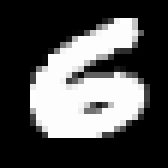

In [132]:
from utils.visualize import visualize

# Get a random sample from the training dataset
rand_index = torch.randint(0, len(train_dataset), (1,)).item()
data_sample, label_sample = train_dataset[rand_index]

print(f"Shown below is the digit {label_sample}, with shape {data_sample.shape}")
visualize(data_sample)

Og tensoren i seg selv ser slik ut:

In [133]:
data_sample

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

### Vi trenger et nettverk
Alle lag i PyTorch arver fra `nn.Module`. Fra [dokumentasjonen](https://pytorch.org/docs/stable/generated/torch.nn.Module.html):

>Base class for all neural network modules. 
>
>Your models should also subclass this class.
>
>Modules can also contain other Modules, allowing to nest them in a tree structure.

Trestrukturen som nevnes er veldig nyttig. Endringer vi gjør på toppen av treet vil propageres ned til enkeltmodulene. Feks det å flytte parametrene over på en GPU.

Vi husker det enkle lineære laget og tanh-funksjonen. De arver nemlig fra `nn.Module`.

In [134]:
print(layer.__class__.__base__)
print(tanh.__class__.__base__)

<class 'torch.nn.modules.module.Module'>
<class 'torch.nn.modules.module.Module'>


Nettverket vi lager inneholder tre lag:
1. `layer1` tar inn et bilde med 28 $\times$ 28 piksler flatet ut til en vektor med 784 features. Denne transformeres til en vektor med et antall features vi velger å være 200.
2. `layer2` tar inn en vektor med 200 features og produserer en vektor med 42 features.
3. `layer3` tar inn en vektor med 42 features og produserer en vektor med samme antall features som antallet siffer vi ønsker å skille mellom.

Mellom hvert lag bruker vi `Tanh` som aktiveringsfunksjon.

Modellen vår implementerer to metoder. Metoden `logits` gir unnormaliserte verdier og vil brukes under trening. Metoden `forward` bruker `softmax` til å normalisere output fra `logits`, og tas i bruk under _inference_.

In [135]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=1*28*28, out_features=200) # Input features are the number of pixels, output features is arbitrary
        self.layer2 = nn.Linear(in_features=200, out_features=42) # Arbitrary number of input- and output-features
        self.layer3 = nn.Linear(in_features=42, out_features=10) # 10 digits to differentiate between

        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1) # Softmax will be computed for each batch element separately 

    def logits(self, data):
        # Flatten the tensor from shape (batch_size, 1, 28, 28) to shape (batch_size, 1 * 28 * 28)
        flattened_data = torch.flatten(data, start_dim=1, end_dim=-1) 

        out = self.layer1(flattened_data) # (batch_size, 784) -> (batch_size, 200)
        out = self.tanh(out)

        out = self.layer2(out) # (batch_size, 200) -> (batch_size, 42)
        out = self.tanh(out)

        out = self.layer3(out) # (batch_size, 42) -> (batch_size, 10)
        return out # Unnormalized data (logits)
    
    def forward(self, data):
        logits = self.logits(data)
        return self.softmax(logits) # Normalized data
    
model = Model() # Initialize model
model.to(device) # Move model to GPU device

Model(
  (layer1): Linear(in_features=784, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=42, bias=True)
  (layer3): Linear(in_features=42, out_features=10, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [136]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}") # .numel() returns the number of elements in a tensor

Number of parameters: 165872


Vi tester modellen på sifferet vi visualiserte tidligere. 

In [137]:
with torch.no_grad(): # Disable gradient calculation for inference
    out = model.forward(data_sample.unsqueeze(0).to(device))
print(f"Distribution over digits: {out}\n")
print(f"The untrained model predicts the digit to be {out.argmax()}, but the correct label is {label_sample}")

Distribution over digits: tensor([[0.1064, 0.1206, 0.0976, 0.0882, 0.0922, 0.0935, 0.1064, 0.0957, 0.1075,
         0.0920]], device='cuda:0')

The untrained model predicts the digit to be 1, but the correct label is 6


## Trening
Vi ser fra resultatene at modellen ikke er i stand til å avgjøre hvilket siffer inputten var. 

Vi har modellen og datasettet. Da er det to viktige ting som mangler for å kunne trene modellen. 
- **En loss-funksjon som definerer målet**
    - Vi ønsker at modellen skal gi høyest sannsynlighet på det rette sifret.
    
- **En algoritme som utfører gradient descent, altså selve maskinlæringen**   
    - Denne algoritmen skal ta utgangspunkt i losset for å forbedre parametrene.
    - Disse er implementert i PyTorch gjennom `torch.optim`.
    - Mer utfyllende detaljer om gradient descent finner du i `bonus_gradients.ipynb`.

Loss-funksjoner sammenlikner en prediksjon mot en fasit, og gjør det mulig å måle hvor gode svarene er fra nettverket mot datasettet.  
Den enkleste er _Mean Squared Error (MSE)_, som kalkulerer gjennomsnittlig kvadrert avvik mellom tilsvarende elementer i hver tensor på tvers av en batch. 

In [138]:
a = torch.Tensor([0, 1])
b = torch.Tensor([0, 1])
loss = F.mse_loss(a, b) # Average of [(0 - 0)^2, (1 - 1)^2] = 0
print(loss)

a = torch.Tensor([0, 1])
b = torch.Tensor([2, 4])
loss = F.mse_loss(a, b) # Average of [(0 - 2)^2, (1 - 4)^2] = Averge of [4, 9] = 6.5
print(loss)

tensor(0.)
tensor(6.5000)


Som loss-funksjon skal vi heller bruke [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Den sammenlikner to sannsynlighetsfordelinger. Matematikken bak er ikke så viktig.

Til gradient descent bruker vi Adam, som står for _Adaptive Moment Estimation_. Også her er ikke matematikken viktig for nå.  
Vi spesifiserer en learning rate som forteller algoritmen hvor store endringer som gjøres på vektene ved hvert oppdateringssteg.

In [139]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [140]:
from tqdm import tqdm # Progress bar

num_epochs = 3

for epoch in range(num_epochs):
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
        for i, (data, targets) in enumerate(progress_bar): 
            data = data.to(device) # Move data to GPU
            targets = targets.to(device) # Move target values to GPU
            pred = model.logits(data) # Query model for predictions
            loss = loss_fn(pred, targets)
            
            loss.backward() # Calculate gradients for all parameters
            optimizer.step() # Uses the calculated gradients on the registered parameters to perform an update
            optimizer.zero_grad() # Remove the gradients
    

Epoch 2: 100%|██████████| 1875/1875 [00:08<00:00, 208.83batch/s]


### Testing av modellen
Vi regner ut nøyaktigheten til modellen på et datasett som ikke er observert under trening.

In [141]:
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)

with torch.no_grad(): # Disable gradient calculation for inference
    correct = 0
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        pred = model.forward(data)
        correct += torch.sum(pred.argmax(dim=1) == targets) # Count number of correct predictions for this batch
    accuracy = correct/len(test_dataset)

print(f"The accuracy of the model on the test set is {accuracy}")

The accuracy of the model on the test set is 0.9541999697685242


Vi tester også på sifferet vi tidligere erfarte at modellen tok feil på. 

tensor([[4.1942e-03, 3.8494e-05, 1.3825e-03, 3.6757e-04, 8.1013e-04, 2.1101e-02,
         9.6070e-01, 6.0615e-07, 1.1384e-02, 1.9921e-05]], device='cuda:0')
The trained model predicts the digit to be 6 with a probability of 0.960701584815979


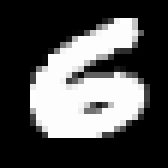

In [148]:
with torch.no_grad(): # Disable gradient calculation for inference
    out = model.forward(data_sample.unsqueeze(0).to(device))
print(out)
print(f"The trained model predicts the digit to be {out.argmax()} with a probability of {out.max()}")
visualize(data_sample)